In [1]:
import os
import cv2
import time
import utils
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
tile_size = 256
mask_15pct = (tile_size*tile_size)*0.15
mask_85pct = (tile_size*tile_size)*0.85

datase_name = 'master_dataset_2'
train_img_path = rf'D:\documents\{datase_name}\train_images\img'
train_masks_path = rf'D:\documents\{datase_name}\train_masks\img'
val_img_path = rf'D:\documents\{datase_name}\val_images\img'
val_masks_path = rf'D:\documents\{datase_name}\val_masks\img'

## Loading data
- reading in geojson
- selectin only polygon shapes

In [3]:
%%time
gdf = utils.load_json_file('raw_osm_extract_01-10-2022.json')
gdf = gpd.GeoDataFrame.from_features(gdf, crs='epsg:4326', columns=['geometry'])
gdf = gdf[gdf.geometry.type == 'Polygon']

CPU times: total: 1.78 s
Wall time: 1.97 s


## Grouping of close polygons 
- get tiles for polygons on big zoom (`zoom = 11` --> `38.218 meters/pixel` --> `~10km img`)
- expolode geometries on multiple tiles
- group polygones based on tiles


- we get polygon pixel coordinates for zoom levels 18 / 17 / 16 

In [4]:
%%time
def get_poly_pixels(geometry, zoom, tile_size):
    lon_coords, lat_coords = np.asarray(geometry.exterior.coords.xy)
    pixel_x, pixel_y = utils.lat_lon_to_pixel_vec(lat_coords, lon_coords, zoom, tile_size)
    
    poly_coords = np.c_[pixel_x, pixel_y]
    poly_coords = poly_coords.reshape((-1,1,2))
    return poly_coords

zoom = 16

gdf['tiles_x'], gdf['tiles_y'] = zip(*gdf.geometry.bounds.apply(lambda x: utils.bounds_to_tiles(*x, zoom=zoom), axis=1))
gdf['poly_px_coords'] = gdf.geometry.apply(get_poly_pixels, args=(zoom, tile_size))

CPU times: total: 9.48 s
Wall time: 10.6 s


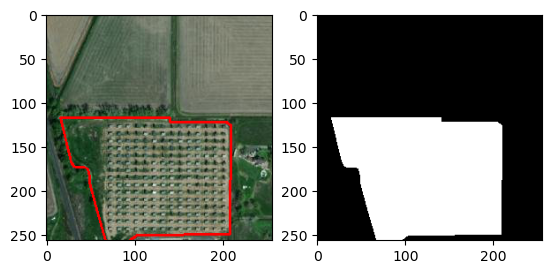

There are 55815 tiles left


Save image for training ([Yes]/No):  '


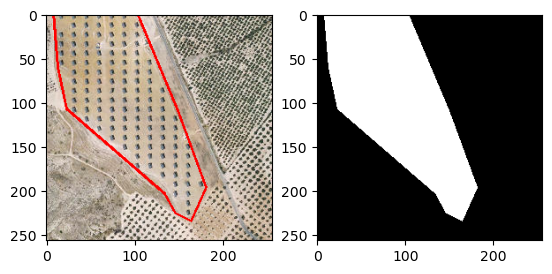

There are 55800 tiles left


In [ ]:
gdf_by_tile = gdf.explode(column='tiles_x').explode(column='tiles_y')
tile_groups = gdf_by_tile.groupby(['tiles_x', 'tiles_y'], sort=False)
tiles_left = tile_groups.ngroups
for tile_coords, tile_data in tile_groups:
    tiles_left -= 1
    if tiles_left > 56000:
        continue
    
    tile_x, tile_y = tile_coords
    tile_offset = (tile_x*tile_size, tile_y*tile_size)
    
    # creating mask and filterig based on it
    poly_rel_px_coords = tile_data.poly_px_coords.map(lambda x: x - tile_offset)
    mask = cv2.fillPoly(np.zeros((256,256)), poly_rel_px_coords.to_list(), color=1)
    if mask.sum() < mask_15pct or mask.sum() > mask_85pct:
        continue

    # downloading image
    source = 'arcgis' if np.random.rand() > 0.7 else 'google_new'
    img = utils.download_img_from_tiles([tile_x], [tile_y], zoom, source='arcgis')

    # displaying image
    outlined_img = img.copy()
    outlined_img = cv2.polylines(outlined_img, poly_rel_px_coords.to_list(), True, (255,0,0), thickness=2)
    utils.display_img_and_masks(outlined_img, mask)
    
    # asking if image should be saved
    print(f'There are {tiles_left} tiles left')
    ignore = input('Save image for training ([Yes]/No): ')
    if ignore:
        continue
    
    # saving images to dataset
    img_name = f'\img_{tile_x}_{tile_y}_{zoom}_{source}.png'
    if np.random.rand() > 0.2:
        cv2.imwrite(f'{train_img_path}{img_name}', img)
        cv2.imwrite(f'{train_masks_path}{img_name}', mask)
    else:
        cv2.imwrite(f'{val_img_path}{img_name}', img)
        cv2.imwrite(f'{val_masks_path}{img_name}', mask)

    clear_output()

In [ ]:
# There are 56859 tiles left